In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
""" --- IMPORTACION LIBRERIAS --- """

import numpy as np
import pickle
import pathlib
import time
import cv2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import torch.nn.functional as F

In [4]:
from PIL import Image
import face_recognition

In [5]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()

In [6]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [10]:
#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.ToTensor()
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [11]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 600
==>>> total testing batch number: 100


In [12]:
for batch_idx, (x, target) in enumerate(train_loader):
    break

In [13]:
samples = x.data.cpu().numpy()

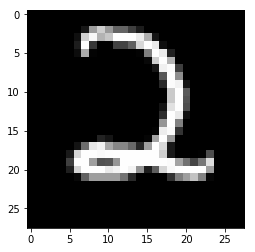

In [14]:
which_sample = 2
plt.imshow(samples[which_sample].reshape(28,28), cmap="gray")

In [15]:
## network
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [18]:
## training
model = MLPNet()

if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

In [19]:
for epoch in range(30):
    # trainning
    ave_loss_train = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        ave_loss_train = ave_loss_train * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x, volatile=True), Variable(target, volatile=True)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss_train, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

==>>> epoch: 0, batch index: 100, train loss: 0.256688, test loss: 0.233275, acc: 0.923
==>>> epoch: 1, batch index: 100, train loss: 0.225994, test loss: 0.168282, acc: 0.946
==>>> epoch: 2, batch index: 100, train loss: 0.135259, test loss: 0.126223, acc: 0.956
==>>> epoch: 3, batch index: 100, train loss: 0.112979, test loss: 0.106205, acc: 0.964
==>>> epoch: 4, batch index: 100, train loss: 0.087054, test loss: 0.088318, acc: 0.971
==>>> epoch: 5, batch index: 100, train loss: 0.081657, test loss: 0.081239, acc: 0.968
==>>> epoch: 6, batch index: 100, train loss: 0.062081, test loss: 0.065759, acc: 0.976
==>>> epoch: 7, batch index: 100, train loss: 0.042542, test loss: 0.059338, acc: 0.979
==>>> epoch: 8, batch index: 100, train loss: 0.055839, test loss: 0.065439, acc: 0.976
==>>> epoch: 9, batch index: 100, train loss: 0.041584, test loss: 0.066380, acc: 0.978
==>>> epoch: 10, batch index: 100, train loss: 0.036102, test loss: 0.055581, acc: 0.979
==>>> epoch: 11, batch index: 1

In [20]:
torch.save(model.state_dict(), "models/mlp_mnist.pt")